In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import sklearn
import tensorboardX

In [2]:
torch.manual_seed(1)    # reproducible

# Hyper Parameters
EPOCH = 20               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 200
LR = 0.001              # learning rate
DOWNLOAD_MNIST = True   # set to False if you have downloaded
TBoard = tensorboardX.SummaryWriter(log_dir='logs')

In [3]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000])


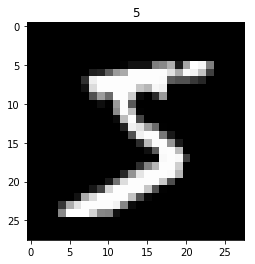

In [4]:
# plot one example
print(train_data.data.size())                 # (60000, 28, 28)
print(train_data.targets.size())               # (60000)
plt.imshow(train_data.data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

In [5]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.targets[:2000]
#test_y = Variable(test_y)

In [6]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.PReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.PReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.fc = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.fc(x)
        return output, x    # return x for visualization

In [9]:
cnn = CNN()
#print(cnn)  # net architecture
#cnn = cnn.cuda()

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted


# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        b_x = x   # batch x
        b_y = y  # batch y

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        
        step_num = epoch * len(train_loader) + step
        imgs_batch = torchvision.utils.make_grid(b_x, nrow=20)
        TBoard.add_image('images', imgs_batch, step_num)
        TBoard.add_graph(cnn, (b_x, ))

    lr = get_lr(optimizer)
    
    test_output, last_layer = cnn(test_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    accuracy = torch.sum(pred_y == test_y).float() / float(test_y.size(0))
    print('Epoch:', epoch,'/',EPOCH, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
            
    TBoard.add_scalar('gMetrics/train_loss', loss.item(), epoch)
    TBoard.add_scalar('gMetrics/test_accuracy', accuracy, epoch)    
    TBoard.add_scalar('weights/conv1', cnn.conv1[0].weight.mean(), epoch)
    TBoard.add_scalar('weights/fc', cnn.fc.weight.mean(), epoch)
    TBoard.add_scalar('grads/conv1', cnn.conv1[0].weight.grad.mean(), epoch)
    TBoard.add_scalar('grads/fc', cnn.fc.weight.grad.mean(), epoch)
    TBoard.add_scalar('grads/lr', lr, epoch)
    

Epoch: 0 / 20 | train loss: 0.1339 | test accuracy: 0.96
Epoch: 1 / 20 | train loss: 0.0323 | test accuracy: 0.97
Epoch: 2 / 20 | train loss: 0.0483 | test accuracy: 0.98
Epoch: 3 / 20 | train loss: 0.0352 | test accuracy: 0.99
Epoch: 4 / 20 | train loss: 0.0232 | test accuracy: 0.98
Epoch: 5 / 20 | train loss: 0.0518 | test accuracy: 0.99
Epoch: 6 / 20 | train loss: 0.0555 | test accuracy: 0.99
Epoch: 7 / 20 | train loss: 0.0465 | test accuracy: 0.99
Epoch: 8 / 20 | train loss: 0.0175 | test accuracy: 0.99
Epoch: 9 / 20 | train loss: 0.0129 | test accuracy: 0.99
Epoch: 10 / 20 | train loss: 0.0156 | test accuracy: 0.99
Epoch: 11 / 20 | train loss: 0.0124 | test accuracy: 0.99
Epoch: 12 / 20 | train loss: 0.0473 | test accuracy: 0.99
Epoch: 13 / 20 | train loss: 0.0059 | test accuracy: 0.99
Epoch: 14 / 20 | train loss: 0.0145 | test accuracy: 0.99
Epoch: 15 / 20 | train loss: 0.0324 | test accuracy: 0.99
Epoch: 16 / 20 | train loss: 0.0013 | test accuracy: 0.99
Epoch: 17 / 20 | train l

In [34]:
x.shape

torch.Size([200, 1, 28, 28])

In [47]:
grid_img = torchvision.utils.make_grid(x, nrow=20);grid_img.shape

torch.Size([3, 302, 602])

In [48]:
imgs = grid_img.permute(1, 2, 0);imgs.shape

torch.Size([302, 602, 3])

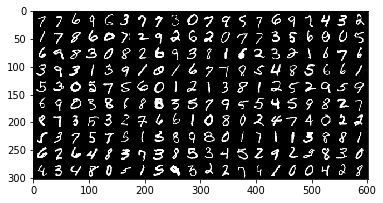

In [46]:
plt.imshow(imgs)

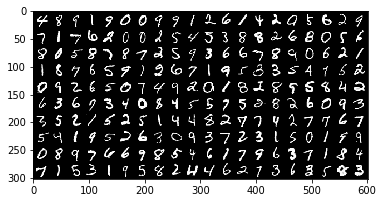

In [14]:
for step, (x, y) in enumerate(train_loader):
    grid_img = torchvision.utils.make_grid(x, nrow=20) #C*H*W
    imgs = grid_img.permute(1, 2, 0) # H*W*C
    plt.imshow(imgs)
    if step == 0:
        break